In [4]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set()

In [5]:
symbol = "AAPL"

In [6]:
url = "https://www.optionistics.com/f/option_chains/"
data = {"symbol": symbol,
        "range": -1,
        "putcall": "C",
        "expiry": -1,
        "greeks": 1,
        "form": 0,
        "sub": 0,
        "lock": 0,
        "v": 1}

html = requests.post(url, data=data)
with open(f"{symbol}.html", 'w') as f:
    f.write(html.content.strip().decode("utf-8"))


In [7]:
html = open(f"{symbol}.html", 'r').read()

In [8]:
soup = BeautifulSoup(html, 'lxml')
# print(soup)

In [9]:
# for index, table in enumerate(soup.find_all('table')):
#     with open(f'{str(index)}.html', 'w') as f:
#         f.write(str(table))

In [10]:
def get_main_info(soup):
    """
    Get spotPrice, impliedVolatility, historicalVolatility
    """
    main_info = soup.find("table", {"class": "chains"})
    return [float(e.text) for e in main_info.find_all("b")[1:-1]]

In [11]:
%%time
implied_volatility, historical_volatility, spot_price = get_main_info(soup)
implied_volatility, historical_volatility, spot_price

Wall time: 2 ms


(0.369, 1.428, 121.26)

In [12]:
%%time
expiration_dates, strikes, prices, midpoints, IVs = [], [], [], [], []
option_chains = soup.find_all('table')[18:-2]
for opt in option_chains:
    date = opt.find("td", {"class": "strikes",
                          "bgcolor": "#ccccff"}).text[1:-8]
    expiration_dates.append(date)

    K = []
    mid = []
    iv = []
    call = []

    for i, tr in enumerate(opt.find_all("tr")[3:]):
        if i % 2 == 0:
            strike = float(tr.find("td").text)
            K.append(strike)
            bid, ask, price = [float(e.text) for e in tr.find_all("td")[2:5]]
            mid.append((bid + ask) / 2)
            call.append(price)
        else:
            vol = float(tr.find_all("td")[1].text)
            iv.append(vol)

        # if i % 2 != 0:
        #     print("Strike \t Bid \t Ask \t Price \t IV")
        #     print(f"{strike}\t{bid}\t{ask}\t{price}\t{vol}")
        #     print()

    strikes.append(np.asarray(K))
    prices.append(np.asarray(call))
    midpoints.append(np.asarray(mid))
    IVs.append(np.asarray(iv))

Wall time: 135 ms


In [13]:
expiration_dates

['March 5, 2021',
 'March 12, 2021',
 'March 19, 2021',
 'March 26, 2021',
 'April 1, 2021',
 'April 9, 2021',
 'April 16, 2021',
 'May 21, 2021',
 'June 18, 2021',
 'July 16, 2021',
 'September 17, 2021',
 'October 15, 2021',
 'January 21, 2022',
 'June 17, 2022',
 'September 16, 2022',
 'January 20, 2023',
 'March 17, 2023']

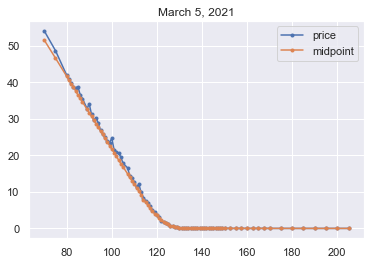

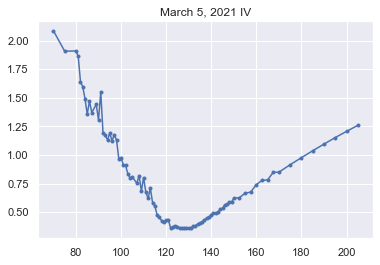

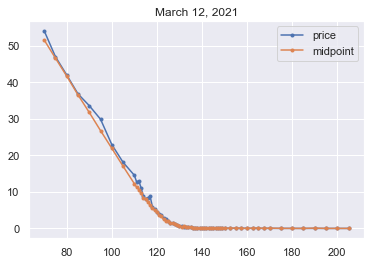

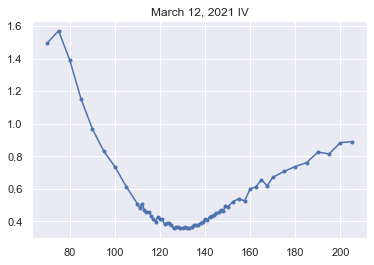

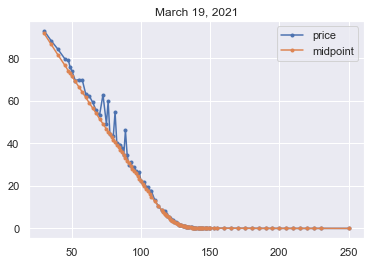

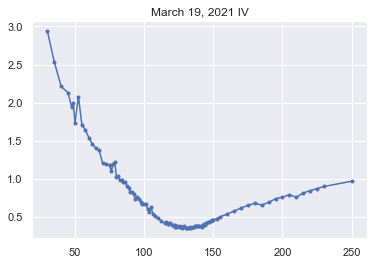

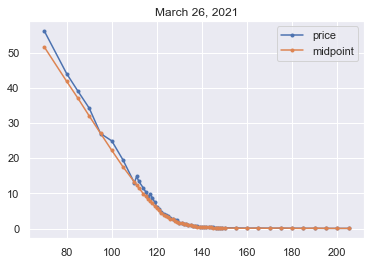

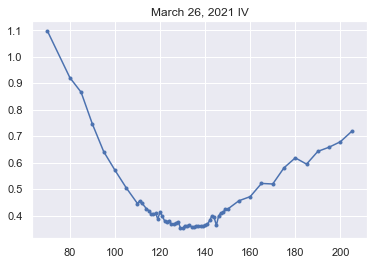

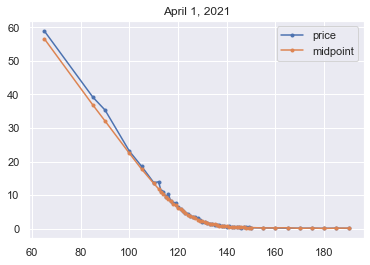

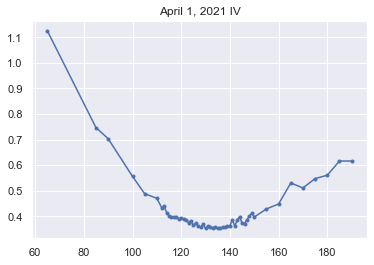

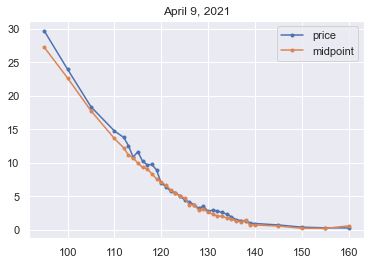

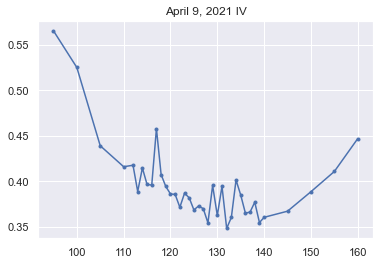

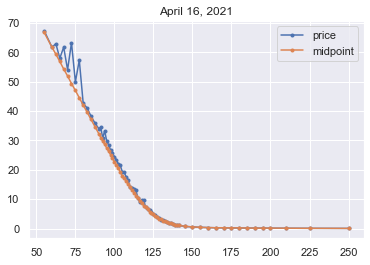

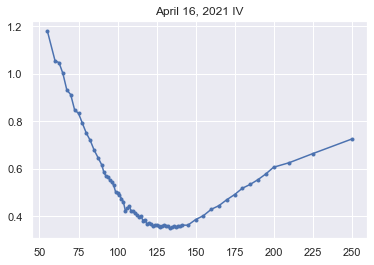

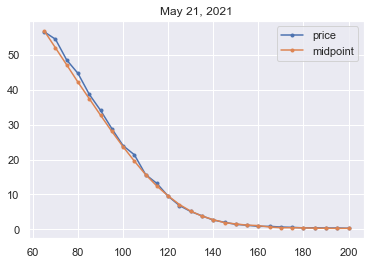

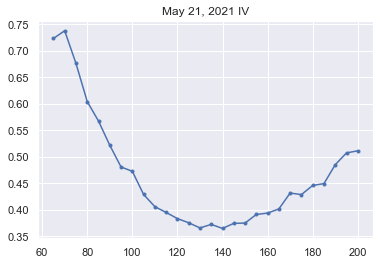

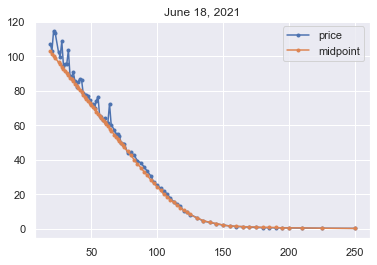

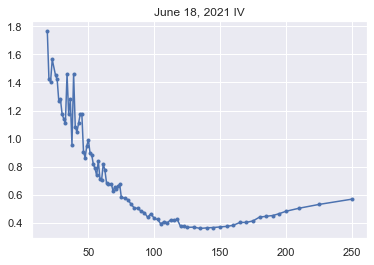

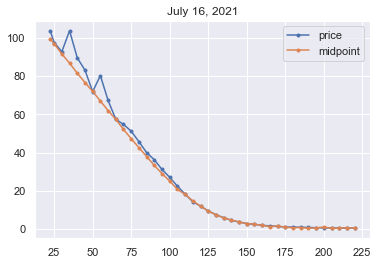

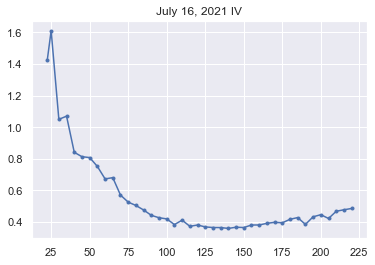

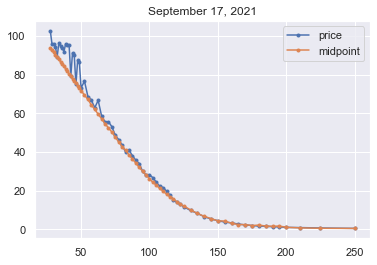

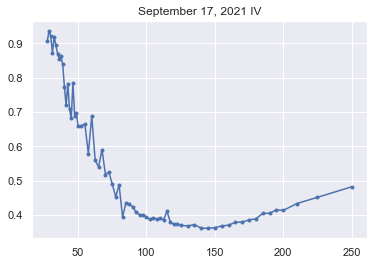

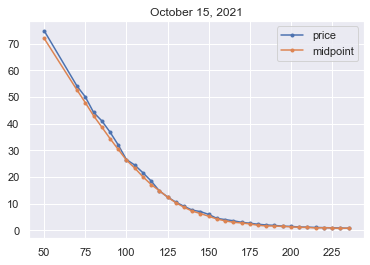

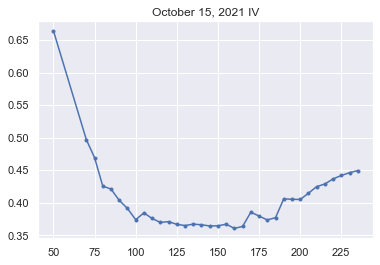

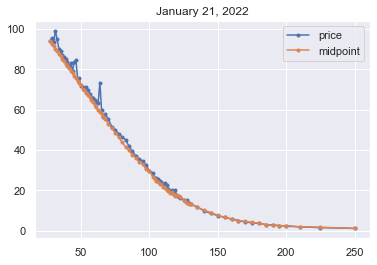

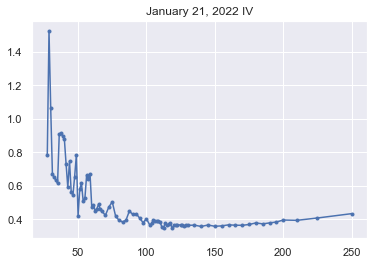

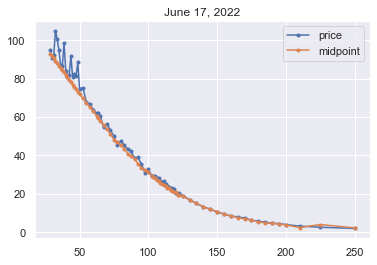

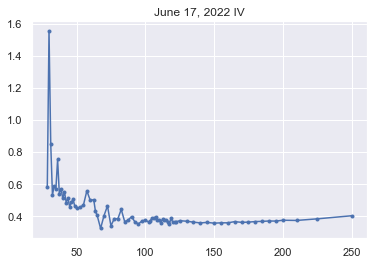

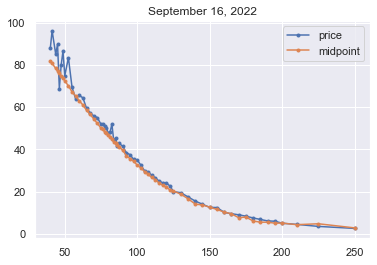

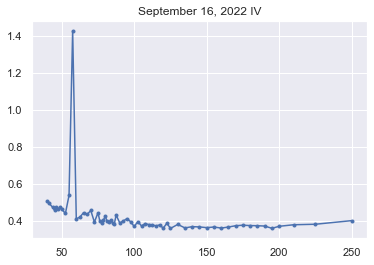

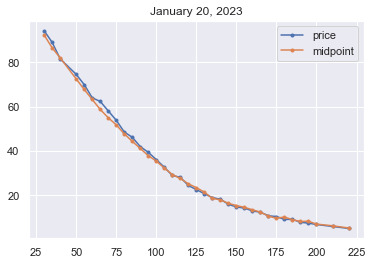

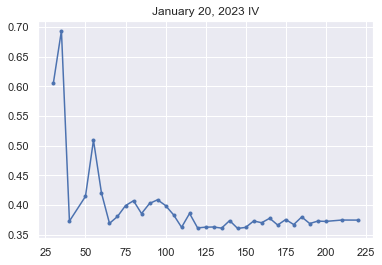

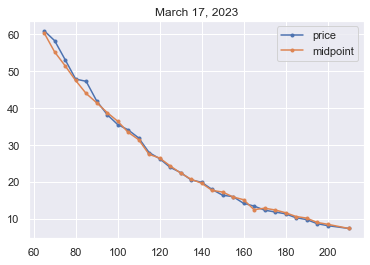

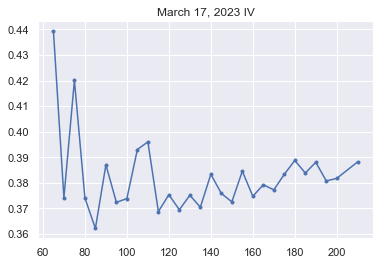

In [14]:
for i, date in enumerate(expiration_dates):
    plt.plot(strikes[i], prices[i], marker=".", label="price")
    plt.plot(strikes[i], midpoints[i], marker=".", label="midpoint")
    plt.title(date)
    plt.legend()
    plt.show()

    plt.plot(strikes[i], IVs[i], marker=".")
    plt.title(date + " IV")
    plt.show()

In [15]:
def pretty_to_isoformat(string):
    month = {"January": "01",
             "February": "02",
             "March": "03",
             "April": "04",
             "May": "05",
             "June": "06",
             "July": "07",
             "August": "08",
             "September": "09",
             "October": "10",
             "November": "11",
             "December": "12"
             }

    date = string.split(" ")
    date[0] = month[date[0]]
    date[1] = "0" + date[1][:-1] if len(date[1][:-1]) == 1 else "" + date[1][:-1]

    return "-".join([date[-1], date[0], date[1]])

In [16]:
exp_dates = [(dt.date.fromisoformat(pretty_to_isoformat(date)) - dt.date.today()).days / 365
             for date in expiration_dates]

In [17]:
risk_free_rate = [[1/365, 5/252, 1/12, 1/6, 1/4, 1/2, 1.0],
                  [0.08400/100, 0.08900/100, 0.11850/100, 0.14750/100, 0.18838/100, 0.20300/100, 0.28375/100]]

array(0.0028375)

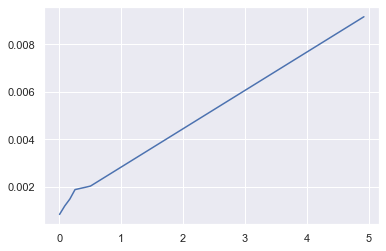

In [18]:
import scipy.interpolate as scip
x = np.arange(1/365, 5, 1/12)
r = scip.interp1d(risk_free_rate[0], risk_free_rate[1], fill_value='extrapolate')
plt.plot(x, r(x))

r(1)